## **Nocturne** | Performance analysis

## Setup

#### Supported metrics

- **Accuracy** to the expert actions. 
- **Euclidean distance** to the expert positions at a given state and timepoint (the L2 distance between the controlled object's XY
  location and its position in the logged history at the same timestep.) `np.linalg.norm(object_xy - log_xy, axis=-1)`
- **Safe distance through the 3-second rule**
- **Mean absolute error to the expert speed**

In [8]:
# Dependencies
import numpy as np
import glob
import pandas as pd
import seaborn as sns
import warnings
import torch
import logging
import os
import matplotlib.pyplot as plt

from typing import Callable
from gym import spaces
from stable_baselines3.common.policies import ActorCriticPolicy
from networks.mlp_late_fusion import LateFusionMLP, LateFusionMLPPolicy

from utils.plot import plot_agent_trajectory
from utils.config import load_config_nb
from utils.eval import EvaluatePolicy
from utils.policies import load_policy

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")

### Configurations

In [6]:
MAX_FILES = 50

# Load config files
env_config = load_config_nb("env_config")
exp_config = load_config_nb("exp_config")
model_config = load_config_nb("model_config")

# Set data path
env_config.data_path = "../data_full/train/"
env_config.num_files = MAX_FILES

# Logging level set to INFO
LOGGING_LEVEL = "INFO"

# Scenes on which to evaluate the models
file_paths = glob.glob(f"{env_config.data_path}" + "/tfrecord*")
eval_files = [os.path.basename(file) for file in file_paths][:MAX_FILES]

### Logging

In [7]:
# Logging
logger = logging.getLogger()
logging.basicConfig(format="%(message)s")
logger.setLevel(LOGGING_LEVEL)

### 1. **Behavioral Cloning (BC)**


In [8]:
# Load trained human reference policy
human_policy = load_policy(
    data_path="../models/il",
    file_name="human_policy_10_scenes_2023_12_29", 
)

# Evaluate policy
evaluator = EvaluatePolicy(
    env_config=env_config, 
    exp_config=exp_config,
    policy=human_policy,
    eval_files=eval_files,
    log_to_wandb=False, 
    deterministic=False,
    reg_coef=0.0,
    return_trajectories=True,
)

df_il_res, df_il_trajs = evaluator._get_scores()
df_il_res['class'] = 'IL'

INFO:root:veh 37 at t = 50 returns None action!
INFO:root:veh 37 at t = 51 returns None action!
INFO:root:veh 44 at t = 75 returns None action!
INFO:root:veh 44 at t = 76 returns None action!
INFO:root:veh 44 at t = 32 returns None action!
INFO:root:veh 44 at t = 33 returns None action!
INFO:root:veh 44 at t = 34 returns None action!
INFO:root:veh 44 at t = 36 returns None action!
INFO:root:veh 44 at t = 37 returns None action!
INFO:root:veh 44 at t = 38 returns None action!
INFO:root:veh 4 at t = 2 returns None action!
INFO:root:veh 41 at t = 1 returns None action!
INFO:root:veh 41 at t = 2 returns None action!
INFO:root:veh 17 at t = 15 returns None action!
INFO:root:veh 17 at t = 16 returns None action!
INFO:root:veh 17 at t = 17 returns None action!
INFO:root:veh 17 at t = 18 returns None action!
INFO:root:veh 17 at t = 19 returns None action!
INFO:root:veh 17 at t = 31 returns None action!
INFO:root:veh 17 at t = 32 returns None action!
INFO:root:veh 17 at t = 33 returns None acti

In [ ]:
df_il_res.round(3)

,run_id,traffic_scene,agents_controlled,reg_coef,act_acc,pos_rmse,speed_mae,goal_rate,veh_edge_cr,veh_veh_cr,num_violations,class
0,None,tfrecord-00004-of-01000_378.json,5,0.0,0.140,2.581,0.288,0.400,0.600,0.000,0,IL
1,None,tfrecord-00003-of-01000_109.json,20,0.0,0.112,119.303,20.169,0.350,0.250,0.100,0,IL
2,None,tfrecord-00004-of-01000_61.json,6,0.0,0.210,4.265,0.463,0.167,0.500,0.000,0,IL
3,None,tfrecord-00012-of-01000_87.json,9,0.0,0.190,181.568,162.275,0.333,0.000,0.000,0,IL
4,None,tfrecord-00007-of-01000_237.json,14,0.0,0.278,8.479,0.513,0.286,0.071,0.000,0,IL
5,None,tfrecord-00005-of-01000_423.json,4,0.0,0.391,6.674,0.776,0.250,0.000,0.000,0,IL
6,None,tfrecord-00012-of-01000_246.json,20,0.0,0.108,162.746,53.993,0.050,0.500,0.200,0,IL
7,None,tfrecord-00012-of-01000_389.json,4,0.0,0.172,123.747,73.352,0.250,0.500,0.000,0,IL
8,None,tfrecord-00001-of-01000_307.json,3,0.0,0.258,4.814,0.485,0.667,0.333,0.000,0,IL
9,None,tfrecord-00004-of-01000_157.json,11,0.0,0.125,260.832,343.664,0.182,0.000,0.545,0,IL


Scene tfrecord-00012-of-01000_389.json


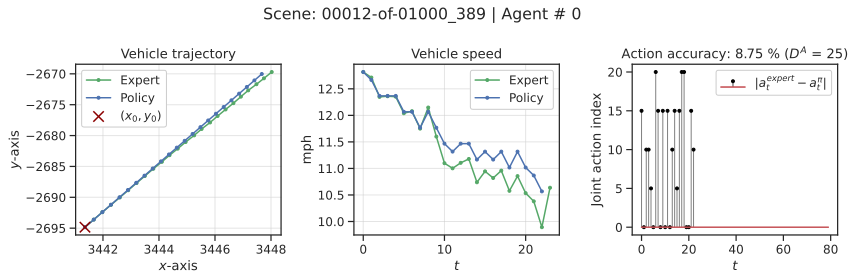

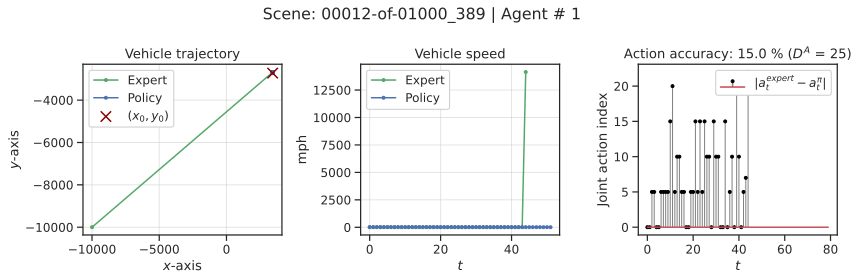

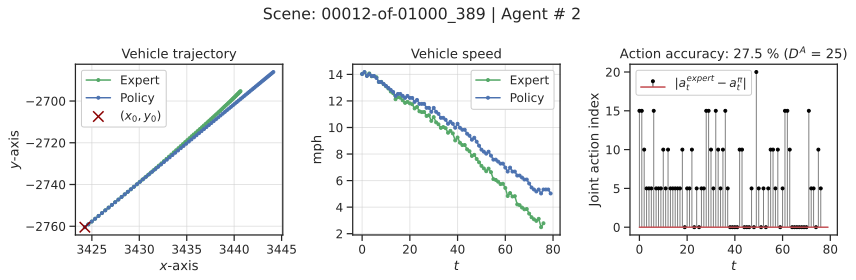

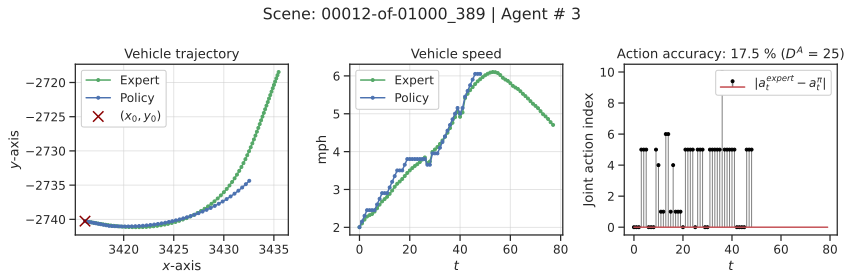

In [ ]:
scene_id = 'tfrecord-00012-of-01000_389.json'

df_scene = df_il_trajs[df_il_trajs.traffic_scene == scene_id]
print(f"Scene {scene_id}")
for agent_id in df_scene.agent_id.unique():
    agent_df = df_scene[df_scene.agent_id == agent_id]
    plot_agent_trajectory(agent_df, evaluator.env.action_space.n)

### 2. **Human-regularized RL**

In [ ]:
RL_POLICY_PATH = "../models/hr_rl"

# Scenes on which to evaluate the models
rl_policy_paths = glob.glob(f"{RL_POLICY_PATH}" + "/*.pt")
rl_policy_names = [os.path.basename(file)[:-3] for file in rl_policy_paths]
reg_weights = [0.0]


rl_policy_names

In [12]:
df_hr_rl_all = pd.DataFrame()

for idx, policy in enumerate(rl_policy_names):

    print(f'Evaluating policy {policy}')

    # Load trained model from artifact dir
    checkpoint = torch.load(f"{RL_POLICY_PATH}/{policy}.pt")
    policy = LateFusionMLPPolicy(
        observation_space=checkpoint['data']['observation_space'],
        action_space=checkpoint['data']['action_space'],
        lr_schedule=checkpoint['data']['lr_schedule'],
        use_sde=checkpoint['data']['use_sde'],
        env_config=env_config,
        mlp_class=LateFusionMLP,
        #mlp_config=checkpoint['model'],
    )
    policy.load_state_dict(checkpoint['state_dict'])
    policy.eval();

    # Evaluate on scenes
    evaluator = EvaluatePolicy(
        env_config=env_config, 
        exp_config=exp_config,
        policy=policy,
        eval_files=eval_files,
        log_to_wandb=False, 
        deterministic=True,
        reg_coef=reg_weights[idx],
        return_trajectories=True,
    )

    df_rl_res, _ = evaluator._get_scores()
    df_rl_res['class'] = f"HR_RL: {reg_weights[idx]}"

    df_hr_rl_all = pd.concat([df_hr_rl_all, df_rl_res])

Evaluating policy nocturne-hr-ppo-12_29_07_55_0.025
Evaluating policy nocturne-hr-ppo-12_29_07_52_0.00


In [14]:
df_hr_rl_all

,run_id,traffic_scene,agents_controlled,reg_coef,act_acc,pos_rmse,speed_mae,goal_rate,veh_edge_cr,veh_veh_cr,num_violations,class
0,None,tfrecord-00004-of-01000_378.json,5,0.025,0.142500,8.358297,1.440388,0.400000,0.000000,0.200000,0,HR_RL: 0.025
1,None,tfrecord-00003-of-01000_109.json,20,0.025,0.105000,119.291848,21.604723,0.800000,0.000000,0.200000,0,HR_RL: 0.025
2,None,tfrecord-00004-of-01000_61.json,6,0.025,0.164583,6.606689,1.097389,0.666667,0.333333,0.000000,0,HR_RL: 0.025
3,None,tfrecord-00012-of-01000_87.json,9,0.025,0.133333,164.076051,139.820955,0.777778,0.000000,0.222222,0,HR_RL: 0.025
4,None,tfrecord-00007-of-01000_237.json,14,0.025,0.184821,13.654639,1.436978,0.714286,0.142857,0.142857,0,HR_RL: 0.025
5,None,tfrecord-00005-of-01000_423.json,4,0.025,0.312500,13.714191,1.655821,0.500000,0.000000,0.000000,0,HR_RL: 0.025
6,None,tfrecord-00012-of-01000_246.json,20,0.025,0.113125,193.501743,98.045055,0.750000,0.150000,0.100000,0,HR_RL: 0.025
7,None,tfrecord-00012-of-01000_389.json,4,0.025,0.121875,123.742438,64.752366,0.750000,0.000000,0.000000,0,HR_RL: 0.025
8,None,tfrecord-00001-of-01000_307.json,3,0.025,0.133333,7.316937,1.267483,0.333333,0.333333,0.000000,0,HR_RL: 0.025
9,None,tfrecord-00004-of-01000_157.json,11,0.025,0.122727,260.829870,315.457867,0.545455,0.000000,0.000000,0,HR_RL: 0.025


### 4. **Summary figures**

### 4.1 What is the overall performance, and how is it distributed across scenes?

- Error distribution

In [57]:
metrics = ['act_acc', 'goal_rate', 'veh_edge_cr', 'veh_veh_cr', 'reg_coef']

# Aggregate performance HR-PPO
df_hr_rl_agg = df_hr_rl_all[metrics].groupby('reg_coef').mean().round(3)

# Aggregate performance IL
df_il_agg = df_il_res[metrics].groupby('reg_coef').mean().round(3)

df_il_agg

,act_acc,goal_rate,veh_edge_cr,veh_veh_cr
reg_coef,,,,
0.0,0.198,0.283,0.265,0.085


In [58]:
df_hr_rl_agg

,act_acc,goal_rate,veh_edge_cr,veh_veh_cr
reg_coef,,,,
0.000,0.047,0.708,0.078,0.117
0.025,0.153,0.624,0.096,0.087


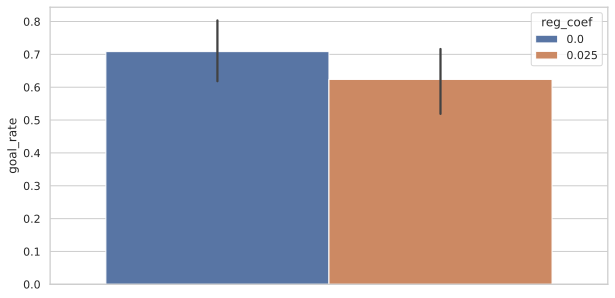

In [80]:
sns.barplot(data=df_hr_rl_all, y='goal_rate', hue='reg_coef', palette="deep");

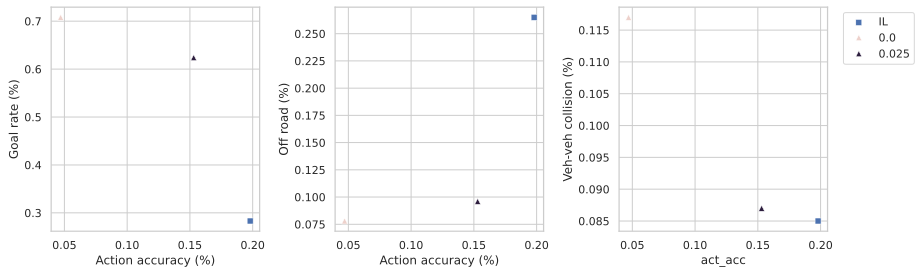

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Accuracy to goal rate
# IL
sns.scatterplot(data=df_il_agg, x='act_acc', y='goal_rate', marker='s', label='IL', ax=axes[0], legend=False)
# HR-RL
sns.scatterplot(data=df_hr_rl_agg, x='act_acc', y='goal_rate', marker='^', hue='reg_coef', ax=axes[0], legend=False)

# Accuracy to off road
# IL
sns.scatterplot(data=df_il_agg, x='act_acc', y='veh_edge_cr', marker='s', label='IL', ax=axes[1], legend=False)
# HR-RL
sns.scatterplot(data=df_hr_rl_agg, x='act_acc', y='veh_edge_cr', marker='^', hue='reg_coef', ax=axes[1], legend=False)


# Accuracy to collision rate
# IL
sns.scatterplot(data=df_il_agg, x='act_acc', y='veh_veh_cr', marker='s', label='IL', ax=axes[2],)
# HR-RL
sns.scatterplot(data=df_hr_rl_agg, x='act_acc', y='veh_veh_cr', marker='^', hue='reg_coef', ax=axes[2])

axes[0].grid(True) 
axes[1].grid(True) 
axes[2].grid(True) 
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

axes[0].set_xlabel('Action accuracy (%)')
axes[0].set_ylabel('Goal rate (%)')
axes[1].set_xlabel('Action accuracy (%)')
axes[1].set_ylabel('Off road (%)')
axes[2].set_ylabel('Veh-veh collision (%)')
plt.tight_layout()

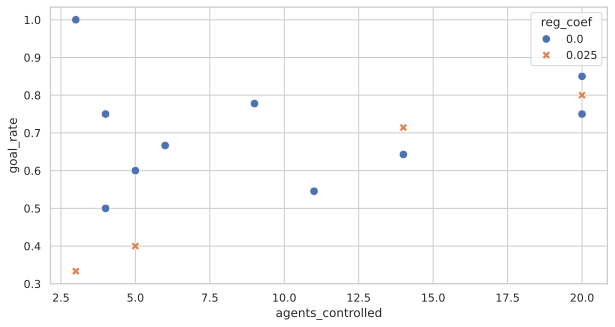

In [85]:
sns.scatterplot(data=df_hr_rl_all, x="agents_controlled", y="goal_rate", hue='reg_coef', palette="deep", style='reg_coef', s=70);

In [79]:
df_hr_rl_all.value_counts('reg_coef')

reg_coef
0.000    10
0.025    10
Name: count, dtype: int64